# Introduction
With the previous Notebooks, I created a cleaned time series DataFrame with no missing values. Now to prepare the modeling phase of my project I will transform the Time Series in a Supervised Learning (SL) dataset to be able to use Classification algorithm to predict the best result of prognose.

In this NoteBook, I will create a simple class that I will be able to use in a pipeline to create a 1st dataset (SL) to estimate the baseline with a Logistic Regression from SkLearn.

The baseline will be estimated on the NET FLOWS columns as features and the target value from the time series dataset.

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import OrdinalEncoder

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import logging
from datetime import datetime
from datetime import timedelta

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import sweetviz as sv

import json

In [2]:
# create the log for this Notebook
now = datetime.now()
filename = 'logs/05-TS2Supervised_a-' + now.strftime("%m%d%Y") + '.log'

logging.basicConfig(filename=filename ,format='%(asctime)s | %(levelname)s: %(message)s', level=20)
logging.info('')
logging.info('***************************************************************************************************')
logging.info('***                                                                                             ***')
logging.info('***   NEW RUN                                                                                   ***')
logging.info('***                                                                                             ***')
logging.info('***************************************************************************************************')

logging.info('I start to run your Notebook ! -- Good Luck :-) It is:  '+ now.strftime("%m/%d/%Y, %H:%M:%S"))


In [3]:
# folder = '../../data source/_anonymized/'
# declare some constants
folder = '_anonymized/'

In [4]:
# read the cleaned csv files

df = pd.read_csv(folder + 'cleaned_time_series.csv')

# initialize constants
funds= np.unique(df['FUND_NAME'])


In [5]:
# transform float to INT
df['POSITIVE_RFP'] = df['POSITIVE_RFP'].astype(int)
df['TARGET'] = df['TARGET'].astype(int)
df['SOFTCLOSING'] = df['SOFTCLOSING'].astype(int)

# transform date to datetime
df['EOM'] = pd.to_datetime(df['EOM'])
df['DATE_SHARE'] = pd.to_datetime(df['DATE_SHARE'])

df['IS_STRATEGIC'] = df['IS_STRATEGIC'].map({'Yes': 1, 'No': 0})


### Encode the RISK_LEVEL

In [6]:
# unique value for RISK LEVEL
try:
    np.unique(df['RISK_LEVEL'])
except:
    None

In [7]:
try:
    df['RISK_LEVEL_VALUE'] = df['RISK_LEVEL'].map({'Low risk': 1, 'Low / moderate risk': 2,  'Moderate risk': 3,
                                              'Moderate / high risk': 4, 'High risk': 5 })
except:
    None
np.unique(df['RISK_LEVEL_VALUE'])

try:
    df.drop('RISK_LEVEL', axis=1, inplace=True)
except:
    logging.warning('RISK_LEVEL already deleted')



### Transform 'object' column to numerical

Remaining 'object' columns are funds classification. Except the Strategy Capabilities which I will OHE later, I will not use directly the other. I decided to encode the value in a numerical field.

In [8]:
df.select_dtypes(include='object').columns.tolist()

['PRODUCT_STRATEGY',
 'ASSET_NAME',
 'FUND_NAME',
 'STRATEGY_CAPABILITY',
 'COUNTRY',
 'PSU']

In [9]:
try:
    X = df.select_dtypes(include='object')
    objcols = df.select_dtypes(include='object').columns.tolist()
    enc = OrdinalEncoder()
    X = enc.fit_transform(X)
    X=pd.DataFrame(X, columns=objcols)
    X
except:
    logging.warning('Unable to ENCODE <object> columns.')

In [10]:
try:
    df=df.drop(objcols, axis=1).merge(X, left_index=True, right_index=True)
except:
    None
    
for c in objcols:
    df[c] = df[c].astype(int)

### Create features with DateTime features.

I create year and month features with the NET FLOW value date.
I will calculate the age of the funds based on the launched date and end of the current year.


In [11]:
try:
    df['FLOWS_MONTH'] = df['EOM'].dt.month
    df['FLOWS_YEAR'] = df['EOM'].dt.year
    df['FLOWS_QUARTER'] = df['EOM'].dt.quarter
except:
    logging.warning('MONTH, YEAR & QUARTER not created in the dataset')

In [12]:
flowscols = [x for x in df.columns if 'FLOW' in x ]
df[flowscols]

,IN_FLOWS,OUT_FLOWS,NET_FLOWS,COMPUTED_FLOWS,DIFF_FLOWS,FLOWS_MONTH,FLOWS_YEAR,FLOWS_QUARTER
0,69669121,-201496427,-131827306,-131827306,-1,1,2010,1
1,89408248,-74310603,15097645,15097645,0,2,2010,1
2,68084125,-163602809,-95518684,-95518684,0,3,2010,1
3,104779215,-87141120,17638095,17638095,0,4,2010,2
4,65517596,-132116073,-66598477,-66598477,0,5,2010,2
...,...,...,...,...,...,...,...,...
9886,8479346,-1279087,7200259,7200259,0,9,2020,3
9887,14776729,-1015792,13760937,13760937,0,10,2020,4
9888,24501245,-359147,24142098,24142098,0,11,2020,4
9889,43874436,-216450,43657986,43657986,0,12,2020,4


In [13]:
# create a FUND_AGE column for each observation by computing difference between
# month of observation and launch date

df['FUND_AGE'] = (df['EOM'] - df['DATE_SHARE']) / timedelta(days=365)

In [14]:
cols = ['EOM','FUND_AGE','SRC_UID','POSITIVE_RFP','DATE_SHARE','IS_STRATEGIC','RISK_LEVEL_VALUE','PSU','PSU_SCORE','TARGET']
df[cols]

,EOM,FUND_AGE,SRC_UID,POSITIVE_RFP,DATE_SHARE,IS_STRATEGIC,RISK_LEVEL_VALUE,PSU,PSU_SCORE,TARGET
0,2010-01-31,14.646575,206670688,0,1995-06-13,0,1,0,0.0,-1
1,2010-02-28,14.723288,206670688,0,1995-06-13,0,1,0,0.0,1
2,2010-03-31,14.808219,206670688,0,1995-06-13,0,1,0,0.0,-1
3,2010-04-30,14.890411,206670688,0,1995-06-13,0,1,0,0.0,1
4,2010-05-31,14.975342,206670688,0,1995-06-13,0,1,0,0.0,-1
...,...,...,...,...,...,...,...,...,...,...
9886,2020-09-30,2.917808,213479867994200,0,2017-10-31,1,3,0,0.0,1
9887,2020-10-31,3.002740,213479867994200,0,2017-10-31,1,3,0,0.0,1
9888,2020-11-30,3.084932,213479867994200,0,2017-10-31,1,3,0,0.0,1
9889,2020-12-31,3.169863,213479867994200,0,2017-10-31,1,3,0,0.0,1


### Features binning
I will create some bin features from numerical value such as Fund Age or Experience.

In [15]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
bin_experience_label = [0,1,2,3,4]
bin_age_label = [0,1,2,3,4,5,6,7,8,9]
df['EXPERIENCE_BIN']=label_encoder.fit_transform(pd.qcut(df['EXPERIENCE'],q=[0, .2, .4, .6, .8, 1],labels=bin_experience_label))
df['FUND_AGE_BIN']=label_encoder.fit_transform(pd.qcut(df['FUND_AGE'],q=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],labels=bin_age_label))
df['DOWNLOADED_DOCUMENTS_BIN']=label_encoder.fit_transform(pd.qcut(df['DOWNLOADED_DOCUMENTS'],q=[0, .2, .4, .6, .8, 1],labels=bin_experience_label))


In [16]:
df.dtypes

SRC_UID                              int64
EOM                         datetime64[ns]
IS_STRATEGIC                         int64
ADMINSTRATION_FEES                 float64
MANAGEMENT_FEES                    float64
                                 ...      
FLOWS_QUARTER                        int64
FUND_AGE                           float64
EXPERIENCE_BIN                       int64
FUND_AGE_BIN                         int64
DOWNLOADED_DOCUMENTS_BIN             int64
Length: 61, dtype: object

In [17]:
# save the dataset for the next Notebook "Modeling"
df.to_csv(folder + 'final_timeseries.csv')

# Custom Transform & Baseline

I decided to work with Custome Transform for the data transformation. This will alows to use the <b>Pipeline</b> capabilities from SKLearn Library and change some parameters and use it in the modeling.

The documentation covering Custom Transformer indicates the fact that removing line from the X (features) set and applying it to target value is not possible. So I will use the Pipeline to transform the Time Series and then I will drop the Nan value from the result.

## Baseline

For the baseline I decided to work with a standard Logistic Regression model and transform the X input variable, which is,the NET FLOWS in a Supervised Learning with a shift of 1 in the past.

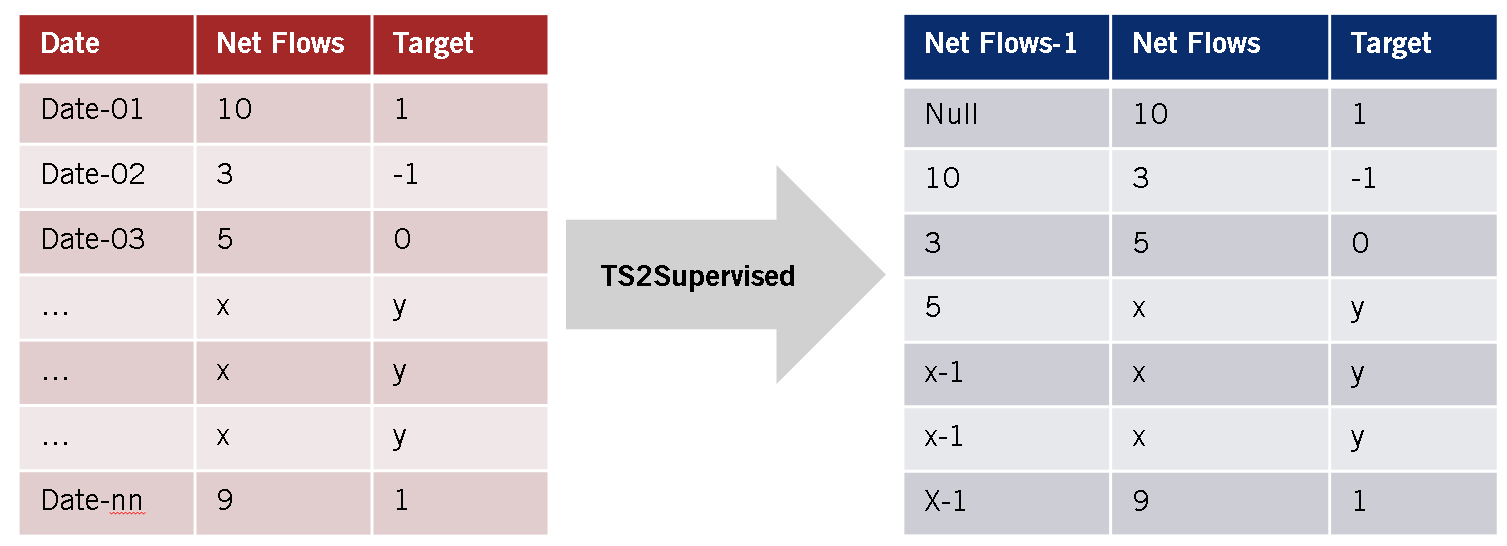


In [18]:
class TSToSupervised(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, breakdown=None, verbose=None, lag=1):
        self.columns = columns
        self.b = breakdown   
        self.verbose = verbose
        self.lag = lag

    
    def transform(self, X,   **transform_params):
        logging.info(self.columns)
        all_cols = self.columns
        all_cols.append(self.b)
        logging.info(all_cols)
        cpy_df = X[all_cols].copy()
        logging.info(self.b)
        # create a list of breakdonw
        b_breakdown = np.unique(cpy_df[self.b])
        
        for b in b_breakdown:
            f = cpy_df[self.b] == b
            for j in range(len(self.columns)):
                for i in range(self.lag):
                    if self.columns[j] != self.b:
                        cpy_df.loc[f,self.columns[j]+'-'+str(i+1)] = cpy_df.loc[f,self.columns[j]].shift(periods=i+1)

        # cpy_df=cpy_df.drop(self.columns,axis=1)


        # cpy_df=cpy_df.merge(X['EOM'], how='inner', left_index=True, right_index=True)    
        cpy_df_dropped = cpy_df.copy()
        if self.verbose:
            print('-------------------------------------------------\n',cpy_df)    

        return cpy_df_dropped
    
    def fit(self, X, y=None, **fit_params):
        return self

In [19]:
# Create X and y
X = df.drop('TARGET', axis=1)
y = df.TARGET

# define columns which will passed to transformer
cols =['NET_FLOWS']
brk='SRC_UID'

# create the steps and the transformation Pipeline
steps = [('ts_2_supervised',TSToSupervised(columns=cols, breakdown=brk, verbose=False, lag=1))]
transformation_pipeline = Pipeline(steps)

transformed_ts_2_sl = transformation_pipeline.fit_transform(X, y)

print(transformed_ts_2_sl.isnull().sum())

transformed_ts_2_sl=transformed_ts_2_sl.merge(y, left_index=True, right_index=True)
transformed_ts_2_sl.dropna(inplace=True)

transformed_ts_2_sl.drop('SRC_UID', axis=1)

NET_FLOWS       0
SRC_UID         0
NET_FLOWS-1    81
dtype: int64


,NET_FLOWS,NET_FLOWS-1,TARGET
1,15097645,-131827306.0,1
2,-95518684,15097645.0,-1
3,17638095,-95518684.0,1
4,-66598477,17638095.0,-1
5,-62096841,-66598477.0,-1
...,...,...,...
9886,7200259,1313987.0,1
9887,13760937,7200259.0,1
9888,24142098,13760937.0,1
9889,43657986,24142098.0,1


In [20]:
# create X and y with transformed 
X = transformed_ts_2_sl.drop(['TARGET','SRC_UID','NET_FLOWS'], axis=1)
y = transformed_ts_2_sl.TARGET

X = X.astype('float64')
y = y.astype('float64')

# split train-test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# create a pipeline for the baseline
steps = [('scaler', StandardScaler()), 
             ('tree', LogisticRegression())]
pipeline = Pipeline(steps) # define the pipeline object.
# call the pipeline and predict for test data
z = pipeline.fit(X_train, y_train)

predictions=z.predict(X_test)
# print(predictions, y_test)

# compute the score as the baseline
z.score(X_test, y_test)

0.4818212708120965

In [21]:
logging.info('Baseline for model is {:.2f} with a Logistic Regression on a simulation of univariate transformation'.format(z.score(X_test, y_test)))

# Time Series 2 Supervised

Now that I have calculated a baseline with a simple class method to transform the time series in a supervised learning dataset for my classification problem I will create new method to be able to transform my time series to the final supervised learning dataset.

The class will used in a pipeline and will pass several parameters for the transformation.

- the <b>column(s)</b> to be transformed
- the <b>method</b> for the transformation such as <i>shift</i>, <i>expanding</i>, <i>rolling windows</i> or <i>ewm</i>
- the <b>number of period(s)</b> to apply; can be positive or negative (lag, lead)
- the <b>breakdown</b> colum to use to compute transformation in a coherent frame of datat; default value is FUND level but if I want I will be able to try some other breakdown such as capabilities
- if the original columns must be delete from the transformation method



In [22]:
class TS2Supervised(BaseEstimator, TransformerMixin):
    def __init__(self, transformation=None, breakdown=None, verbose=None, interpolation=None):
        self.transformation = transformation
        self.b = breakdown   
        self.verbose = verbose
        self.interpolation = interpolation
        logging.info('Transformation called with interpolation={}, verbose={}, breakdown-level={} and dictionary \n{}'.format(interpolation, verbose, breakdown, transformation))
        logging.info('-------------------------------------------------------------------------------------------')

        
    
    def transform(self, X,   **transform_params):
        '''
        The transformation is a list of dictionaries. Each dictionray is a transformation
        for a set of columns and must contain
        - a list of columns
        - the method (split, rolling window, expanding or ewm)
        - the period to apply
        - if the original columns must deleted
        '''
        # create a list of breakdonw        
        b_breakdown = np.unique(X[self.b])        
        X_temp = X.copy()
        # enumerate the list of dictionaries
        for trans in self.transformation:
            #ogging.info('Entering in enumerate transformation Columns in X_temp \n{}'.format((X_temp.columns)))
            # assign the trans variable to a dico variable
            dico = trans
            for i, (k, v) in enumerate(dico.items()):
                logging.info('index {} - dico value for key {} is {}'.format(i, k, v))            
                # enumerate dictionary key and value
            
            '''for  skew method I must compute the number of columns and the ratio to apply'''
            n_periods=np.linspace(1,0,len(dico['period'])+2).tolist()
            n_periods.remove(1)

            logging.info('(n) periods {} for the skew method is {}'.format(dico['period'],n_periods))  
            
            all_cols = dico['cols'].copy()
            all_cols.append(self.b)
            cpy_df = X_temp[all_cols].copy()            
            for b in b_breakdown:
                f = cpy_df[self.b] == b
                for j in range(len(dico['cols'])):
                    

                    
                    for i in (dico['period']):
                        if dico['cols'][j] != self.b:
                            colfix=''
                            if dico['method']=='shift':
                                colfix='s'
                                cpy_df.loc[f,dico['cols'][j]+'-s'+str(i)] = cpy_df.loc[f,dico['cols'][j]].shift(periods=i)
                            if dico['method']=='rolling':
                                colfix='r'
                                cpy_df.loc[f,dico['cols'][j]+'-r'+str(i)] = cpy_df.loc[f,dico['cols'][j]].rolling(i).mean()
                            if dico['method']=='ewm':
                                colfix='e'
                                cpy_df.loc[f,dico['cols'][j]+'-e'+str(i)] = cpy_df.loc[f,dico['cols'][j]].ewm(com=i).mean()
                            if dico['method']=='expanding':
                                colfix='x'
                                cpy_df.loc[f,dico['cols'][j]+'-x'+str(i)] = cpy_df.loc[f,dico['cols'][j]].expanding(min_periods=i).mean()

                                
                            if self.interpolation and colfix != '':
                                cpy_df.loc[f,dico['cols'][j]+'-'+colfix+str(i)]=cpy_df.loc[f,dico['cols'][j]+'-'+colfix+str(i)].interpolate(limit_direction='both')                                

            c1 = X.columns.tolist()
            c2 = cpy_df.columns.tolist()
            intersection_set = set.intersection(set(c1), set(c2))    
            X_temp = X_temp.merge(cpy_df.drop(intersection_set,axis=1), left_index=True, right_index=True).copy()
            logging.info('Columns in X_temp {}'.format(len(X_temp.columns)))
            #ogging.info('Columns in X_temp \n{}'.format((X_temp.columns)))
            
            if dico['original'] != True:
                # delete the original column(s)
                X_temp.drop(dico['cols'], axis=1, inplace=True)
            logging.info('New columns added to the dataframe: {}'.format(cpy_df.drop(intersection_set,axis=1).columns))




        return X_temp
    
    def fit(self, X, y=None, **fit_params):
        logging.info('Initializing with Columns in X {}'.format(len(X.columns)))
        return self

# Apply CustomTransformation

The next code will apply the custom transformtion (Time Serie 2 SL) with a simple configuration file. The configuration file is a dictionary which contains "feature", method to apply "shift", "folling window", "expanding" or "ewm". A list of "period" to be used with the method and if the original value must be deleted or not from the sult dataset

The Custom Transformer takes another important parameter named "interpolation". I decided to implement this because when applying some method like "shift" the result dataset contains NaN value which is not allowed when using the data in a model. The data can be dropped before modeling or to keep the observations I decided to allow the Custom Transformer to interpolate() the colum value by filling the NaN. This will allow the program to have a full pipeline with transformer, outliers detection and modeling.

In [23]:
# Create X and y
X = df.drop('TARGET', axis=1)
y = df.TARGET

# define columns which will passed to transformer for the grouping (brk)
# when applying method such as shift or expanding, I want to maintain the
# fund grouping (or other attribute to set in brk).

brk='SRC_UID'


# Read configuration file
try:
    with open('config_transformation.json') as data_file:
        data_loaded = json.load(data_file)
        trans = data_loaded
except:
    logging.warning('No configuration file found. Create a sample file')
    trans = []
    dico= {}
    dico['cols'] = ['IN_FLOWS']
    dico['method'] = 'shift'
    dico['period'] = [1]
    dico['original'] = True
    trans.append(dico)
    # save the config
    with open('config_transformation.json', 'w') as f:
        json.dump(trans, f)
    
# create the steps and the transformation Pipeline
steps = [('ts_2_supervised',TS2Supervised(transformation=trans, breakdown=brk
                                          , verbose=False, interpolation=True))]
transformation_pipeline = Pipeline(steps)

test_transformed_pipeline = transformation_pipeline.fit_transform(X, y)

In [24]:
# merge the result transformed set witht the target value
final_df=test_transformed_pipeline.merge(y, left_index=True, right_index=True).dropna()
final_df

,SRC_UID,EOM,IS_STRATEGIC,ADMINSTRATION_FEES,MANAGEMENT_FEES,MULTI_MANAGER_STRUCTURE,EXPERIENCE,SOFTCLOSING,DATE_SHARE,CNT_SHARE,...,EXPERIENCE_BIN,FUND_AGE_BIN,DOWNLOADED_DOCUMENTS_BIN,IN_FLOWS-s1,IN_FLOWS-s2,IN_FLOWS-s3,AUM-r2,AUM-r5,AUM-r7,TARGET
0,206670688,2010-01-31,0,0.000277,0.001631,1,0.0,0,1995-06-13,12,...,0,7,0,69669121.0,69669121.0,69669121.0,713840440.5,654958566.2,6.137747e+08,-1
1,206670688,2010-02-28,0,0.000277,0.001631,1,0.0,0,1995-06-13,12,...,0,7,0,69669121.0,69669121.0,69669121.0,713840440.5,654958566.2,6.137747e+08,1
2,206670688,2010-03-31,0,0.000277,0.001631,1,0.0,0,1995-06-13,12,...,0,7,0,89408248.0,69669121.0,69669121.0,673792629.5,654958566.2,6.137747e+08,-1
3,206670688,2010-04-30,0,0.000277,0.001631,1,0.0,0,1995-06-13,12,...,0,7,0,68084125.0,89408248.0,69669121.0,634908810.0,654958566.2,6.137747e+08,1
4,206670688,2010-05-31,0,0.000277,0.001631,1,0.0,0,1995-06-13,12,...,0,7,0,104779215.0,68084125.0,89408248.0,610520193.5,654958566.2,6.137747e+08,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9886,213479867994200,2020-09-30,1,0.000300,0.005000,0,0.0,0,2017-10-31,8,...,0,1,0,2226192.0,7838181.0,14258055.0,499453583.0,466825279.2,4.407168e+08,1
9887,213479867994200,2020-10-31,1,0.000300,0.005000,0,0.0,0,2017-10-31,8,...,0,1,0,8479346.0,2226192.0,7838181.0,509903678.0,489066372.0,4.679802e+08,1
9888,213479867994200,2020-11-30,1,0.000300,0.005000,0,0.0,0,2017-10-31,8,...,0,1,0,14776729.0,8479346.0,2226192.0,547350187.0,516972277.8,4.898324e+08,1
9889,213479867994200,2020-12-31,1,0.000300,0.005000,0,0.0,0,2017-10-31,8,...,0,1,0,24501245.0,14776729.0,8479346.0,605626878.0,546329817.0,5.223694e+08,1


### Content of final_df
The final dataframe is the original dataframe with the transformed columns.

For exemple, the following configuration file applies transformation to the AUN and FLOWS columns.

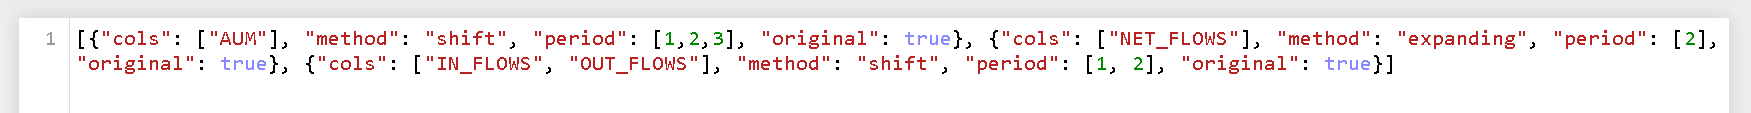

In [25]:
logging.info('Number of NULL value after transformation is {}'.format(test_transformed_pipeline.isnull().sum().sum()) )

# Test the transformation

I will test the transformation with a LogisticRegression model. To do that, I select the transformed columns (in my case they contain a 's, x, e or r' and the original columns. This list is stored in a features ist variable hich will be used to create X dataset.

In [26]:
# create the features list
features = [x for x in final_df.columns if 'x' in x or 'e' in x  or 's' in x or 'r' in x]
features.append('TARGET')
features.append('FLOWS_YEAR')
features.append('FLOWS_MONTH')
# I keep the SRC_UID but I will not use it in the modeling process
features.append('SRC_UID')
logging.info('List of features selected for modeling \n{} with {} rows'.format(features, final_df.shape[0]))
features

['IN_FLOWS-s1',
 'IN_FLOWS-s2',
 'IN_FLOWS-s3',
 'AUM-r2',
 'AUM-r5',
 'AUM-r7',
 'TARGET',
 'FLOWS_YEAR',
 'FLOWS_MONTH',
 'SRC_UID']

## Display the dataset analysis with SweetViz
I create a SwetViz report with the final dataset and scope of the features transformed

In [27]:
feature_config = sv.FeatureConfig(skip="SRC_UID", force_num=["TARGET"])
my_report = sv.analyze(final_df[features], feat_cfg=feature_config, target_feat='TARGET')
# my_report.show_html() 

In [28]:
# create X and y with transformed 
X = final_df[features].drop(['TARGET','SRC_UID'], axis=1)
y = final_df.TARGET

X=X.astype('float64')
y=y.astype('float64')
# split train-test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# create a pipeline for the baseline
steps = [('scaler', StandardScaler()), 
             ('tree', LogisticRegression())]
pipeline = Pipeline(steps) # define the pipeline object.
# call the pipeline and predict for test data
z = pipeline.fit(X_train, y_train)

predictions=z.predict(X_test)
# print(predictions, y_test)

# compute the score as the baseline
print('Score value after transformation is {:.4f}'.format(z.score(X_test, y_test)))

Score value after transformation is 0.5078


In [29]:
logging.info('Score value after transformation is {:.4f}'.format(z.score(X_test, y_test)))